In [196]:
import pandas as pd
import optuna
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import seaborn as sb
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

In [197]:
df_test = pd.read_csv(r'test.csv')
df_train = pd.read_csv(r'train.csv')

In [198]:
df_train.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [199]:
df_train.shape

(8693, 14)

In [200]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


In [201]:
df_train.describe()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
count,8514.000000,8512.000000,8510.000000,8485.000000,8510.000000,8505.000000
mean,28.827930,224.687617,458.077203,173.729169,311.138778,304.854791
std,14.489021,666.717663,1611.489240,604.696458,1136.705535,1145.717189
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,38.000000,47.000000,76.000000,27.000000,59.000000,46.000000
max,79.000000,14327.000000,29813.000000,23492.000000,22408.000000,24133.000000


In [202]:
print(df_train.isna().sum())

PassengerId       0
HomePlanet      201
CryoSleep       217
Cabin           199
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
Transported       0
dtype: int64


In [203]:
print(df_test.isna().sum())

PassengerId       0
HomePlanet       87
CryoSleep        93
Cabin           100
Destination      92
Age              91
VIP              93
RoomService      82
FoodCourt       106
ShoppingMall     98
Spa             101
VRDeck           80
Name             94
dtype: int64


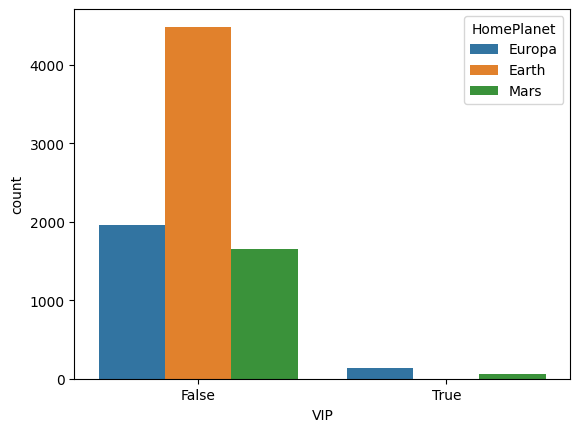

In [204]:
sb.countplot(data=df_train, x='VIP',
             hue='HomePlanet')
plt.show()

In [205]:
df_train['HomePlanet'] = df_train['HomePlanet'].fillna(pd.Series(np.where(df_train['VIP'] == True, 'Europa', 'Earth'), index=df_train.index))

In [206]:
cols_for_cryo_sleep = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
df_train['CryoSleep'] = df_train['CryoSleep'].fillna((df_train[cols_for_cryo_sleep] != 0.0).any(axis=1))

imputer = SimpleImputer(strategy='mean')
df_train[['Age']] = imputer.fit_transform(df_train[['Age']])
df_test[['Age']] = imputer.transform(df_test[['Age']])

# Для категориальных признаков, таких как 'Cabin' и 'VIP', вы можете заполнить пропущенные значения наиболее часто встречающимися значениями
imputer = SimpleImputer(strategy='most_frequent')
df_train[['Cabin', 'VIP']] = imputer.fit_transform(df_train[['Cabin', 'VIP']])
df_test[['Cabin', 'VIP']] = imputer.transform(df_test[['Cabin', 'VIP']])

C:\Users\miron\AppData\Local\Temp\ipykernel_21700\4184519789.py:2: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_train['CryoSleep'] = df_train['CryoSleep'].fillna((df_train[cols_for_cryo_sleep] != 0.0).any(axis=1))


In [207]:
df_train[['Deck', 'Num', 'Side']] = df_train['Cabin'].str.split('/', expand=True)
df_train = df_train.drop(columns=["Name", "Cabin", "Num"])

In [208]:
df_train['Destination'] = df_train['Destination'].fillna('Unknown')

In [209]:
df_VIP = df_train.loc[((df_train["VIP"] == True) & (df_train["CryoSleep"] == False))]
df_com = df_train.loc[((df_train["VIP"] == False) & (df_train["CryoSleep"] == False))]

for c in cols_for_cryo_sleep:
    mean_com = df_com[c].mean()
    mean_VIP = df_VIP[c].mean()
    df_train[c] = df_train.apply(lambda row: 0 if row['CryoSleep'] else (mean_com if not(row['VIP']) else mean_VIP) if pd.isnull(row[c]) else row[c], axis=1)

In [210]:
le = LabelEncoder()
df_train['Deck'] = le.fit_transform(df_train['Deck'])
df_train['Side'] = le.fit_transform(df_train['Side'])
df_train['HomePlanet'] = le.fit_transform(df_train['HomePlanet'])
df_train['Destination'] = le.fit_transform(df_train['Destination'])

df_train['VIP'] = df_train['VIP'].astype(int)
df_train['CryoSleep'] = df_train['CryoSleep'].astype(int)

In [211]:
listTransported = [False, True]
mapTransported = {i: listTransported.index(i) for i in listTransported}
df_train['Transported'] = df_train['Transported'].map(mapTransported)

In [212]:
passenger_ids = df_test['PassengerId'].copy()

df_train = df_train.drop(columns=["PassengerId"])
df_test = df_test.drop(columns=["PassengerId"])

df_test['HomePlanet'] = df_test['HomePlanet'].fillna(pd.Series(np.where(df_test['VIP'] == True, 'Europa', 'Earth'), index=df_test.index))

cols_for_cryo_sleep = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
df_test['CryoSleep'] = df_test['CryoSleep'].fillna((df_test[cols_for_cryo_sleep] != 0.0).any(axis=1))
df_test = df_test.dropna(subset=["Age", "Cabin", "VIP"])

df_test[['Deck', 'Num', 'Side']] = df_test['Cabin'].str.split('/', expand=True)
df_test = df_test.drop(columns=["Name", "Cabin", "Num"])

df_test['Destination'] = df_test['Destination'].fillna('Unknown')

df_VIP = df_test.loc[((df_test["VIP"] == True) & (df_test["CryoSleep"] == False))]
df_com = df_test.loc[((df_test["VIP"] == False) & (df_test["CryoSleep"] == False))]

for c in cols_for_cryo_sleep:
    mean_com = df_com[c].mean()
    mean_VIP = df_VIP[c].mean()
    df_test[c] = df_test.apply(lambda row: 0 if row['CryoSleep'] else (mean_com if not(row['VIP']) else mean_VIP) if pd.isnull(row[c]) else row[c], axis=1)

le = LabelEncoder()
df_test['Deck'] = le.fit_transform(df_test['Deck'])
df_test['Side'] = le.fit_transform(df_test['Side'])
df_test['HomePlanet'] = le.fit_transform(df_test['HomePlanet'])
df_test['Destination'] = le.fit_transform(df_test['Destination'])

df_test['VIP'] = df_test['VIP'].astype(int)
df_test['CryoSleep'] = df_test['CryoSleep'].astype(int)

C:\Users\miron\AppData\Local\Temp\ipykernel_21700\2393955787.py:9: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_test['CryoSleep'] = df_test['CryoSleep'].fillna((df_test[cols_for_cryo_sleep] != 0.0).any(axis=1))


In [213]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   HomePlanet    8693 non-null   int32  
 1   CryoSleep     8693 non-null   int32  
 2   Destination   8693 non-null   int32  
 3   Age           8693 non-null   float64
 4   VIP           8693 non-null   int32  
 5   RoomService   8693 non-null   float64
 6   FoodCourt     8693 non-null   float64
 7   ShoppingMall  8693 non-null   float64
 8   Spa           8693 non-null   float64
 9   VRDeck        8693 non-null   float64
 10  Transported   8693 non-null   int64  
 11  Deck          8693 non-null   int32  
 12  Side          8693 non-null   int32  
dtypes: float64(6), int32(6), int64(1)
memory usage: 679.3 KB


In [214]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4277 entries, 0 to 4276
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   HomePlanet    4277 non-null   int32  
 1   CryoSleep     4277 non-null   int32  
 2   Destination   4277 non-null   int32  
 3   Age           4277 non-null   float64
 4   VIP           4277 non-null   int32  
 5   RoomService   4277 non-null   float64
 6   FoodCourt     4277 non-null   float64
 7   ShoppingMall  4277 non-null   float64
 8   Spa           4277 non-null   float64
 9   VRDeck        4277 non-null   float64
 10  Deck          4277 non-null   int32  
 11  Side          4277 non-null   int32  
dtypes: float64(6), int32(6)
memory usage: 300.9 KB


In [215]:
X = df_train.drop('Transported', axis=1)
y = df_train['Transported']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [216]:
def objective(trial):
    param = {
        'iterations': trial.suggest_int('iterations', 50, 300),
        'depth': trial.suggest_int('depth', 4, 10),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
        'random_strength': trial.suggest_int('random_strength', 0, 100),
        'bagging_temperature': trial.suggest_loguniform('bagging_temperature', 0.01, 100.00),
        'od_type': trial.suggest_categorical('od_type', ['IncToDec', 'Iter']),
        'od_wait': trial.suggest_int('od_wait', 10, 50)
    }
    
    model = CatBoostClassifier(**param, silent=True)
    cat_features = ['HomePlanet', 'CryoSleep', 'Destination', 'VIP', 'Deck', 'Side']
    model.fit(X_train, y_train, cat_features=cat_features)
    preds = model.predict(X_val)
    accuracy = accuracy_score(y_val, preds)
    return accuracy

In [217]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

[I 2024-03-16 23:19:08,922] A new study created in memory with name: no-name-7390b703-4da9-49a4-a07d-a8aeb42a821f
C:\Users\miron\AppData\Local\Temp\ipykernel_21700\3332402842.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
C:\Users\miron\AppData\Local\Temp\ipykernel_21700\3332402842.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'bagging_temperature': trial.suggest_loguniform('bagging_temperature', 0.01, 100.00),
[I 2024-03-16 23:19:10,005] Trial 0 finished with value: 0.7757331799884991 and parameters: {'iterations': 91, 'depth': 8, 'learning_rate': 0.05702616452942415, 'random_strength': 7

KeyboardInterrupt: 

In [ ]:
print('Best trial:')
trial = study.best_trial
print(" Value: ", trial.value)
print(" Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

In [ ]:
best_params = study.best_trial.params
model = CatBoostClassifier(**best_params, silent=True)
model.fit(X_train, y_train)

In [ ]:
predictions = model.predict(X_val)
accuracy = accuracy_score(y_val, predictions)
print(f'Точность модели CatBoost Optuna на валидационных данных: {accuracy}')

In [ ]:
model_test_predictions = model.predict(df_test)
model_test_predictions = (model_test_predictions == 1)

In [ ]:
model_submission = pd.DataFrame({'PassengerId': passenger_ids, 'Transported': model_test_predictions})
model_submission.to_csv('optuna_submission.csv', index=False)
print('Файл optuna_submission.csv успешно сохранен.')

In [ ]:
base_model = RandomForestClassifier()
base_model.fit(X_train, y_train)

In [ ]:
base_predictions = base_model.predict(X_val)
base_accuracy = accuracy_score(y_val, base_predictions)
print(f'Точность базового классификатора на валидационных данных: {base_accuracy}')

In [ ]:
model = CatBoostClassifier(verbose=0)

In [ ]:
cat_features = ['HomePlanet', 'CryoSleep', 'Destination', 'VIP', 'Deck', 'Side']
model.fit(X_train, y_train, cat_features=cat_features)

In [ ]:
predictions = model.predict(X_val)
accuracy = accuracy_score(y_val, predictions)
print(f'Точность модели CatBoost на валидационных данных: {accuracy}')

In [ ]:
base_test_predictions = base_model.predict(df_test)
model_test_predictions = model.predict(df_test)

base_test_predictions = (base_test_predictions == 1)
model_test_predictions = (model_test_predictions == 1)

In [ ]:
base_submission = pd.DataFrame({'PassengerId': passenger_ids, 'Transported': base_test_predictions})
base_submission.to_csv('forest_submission.csv', index=False)
print('Файл forest_submission.csv успешно сохранен.')

model_submission = pd.DataFrame({'PassengerId': passenger_ids, 'Transported': model_test_predictions})
model_submission.to_csv('catboost_submission.csv', index=False)
print('Файл catboost_submission.csv успешно сохранен.')